In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.gaussian_process as gp
from scipy.integrate import solve_ivp
import scipy.linalg as la
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from sur_data import rw_metropolis_hastings

In [8]:
np.savez('test.npz',myfloat=.1)

In [5]:
%matplotlib notebook
plt.style.use('seaborn')

### Forward Model

In [9]:
def lotka_volterra(t,y,a,b,c,d):
    dy = np.empty_like(y)
    # switched to match
    dy[0] = d*y[0]*y[1]-c*y[0]
    dy[1] = a*y[1]-b*y[0]*y[1]
    return dy

def solve_lv(T,y0,a,b,c,d):
    sol = solve_ivp(lotka_volterra,(T[0],T[-1]),y0,t_eval=T,args=(a,b,c,d))
    return sol.y

## Generate observation data

In [10]:
# choose true parameters
y0 = [2,.5]
a = 1
b = 1
c = 1
d = 1

# generate simulated data
T = np.linspace(0,10,10)
y = solve_lv(T,y0,a,b,c,d)

# set random seed
np.random.seed(2021)

# add noise
sigma = 0.02
y_noisy = np.abs(y + sigma*np.random.randn(y.shape[0],y.shape[1]))

# generate initial sample for MCMC
x0 = np.array([y0[0],y0[1],b,c])+.1*np.random.randn(4)

In [11]:
y_noisy

array([[2.02977218, 0.99350953, 0.46351541, 0.28855728, 0.42494348,
        1.56646565, 2.1801117 , 1.1079175 , 0.51902165, 0.31951711],
       [0.50248414, 0.28268093, 0.43186564, 0.85787259, 1.774839  ,
        2.1697727 , 0.56175893, 0.29433524, 0.36147151, 0.76949221]])

## Standard case (no surrogate data)

In [26]:
# define likelihood and prior
# gaussian likelihood
def llh_std(y):
    return -((y-y_noisy)**2).sum()

# uniform prior
def lpr_std(x):
    if np.all((0<x)&(x<10)):
        return 0
    else:
        return np.NINF
    
# define forward model
def f_std(x):
    return solve_lv(T,x[:2],1,x[2],x[3],1)

In [27]:
# sample
cov = .03*np.eye(4)
X_std = rw_metropolis_hastings(f_std,llh_std,lpr_std,cov,x0,n=100000,burn_in=10000,update=False,verbose=False)

kdes_std = []
for col in X_std.T:
    kdes_std.append(gaussian_kde(col))

acceptance rate: 0.2756


<IPython.core.display.Javascript object>


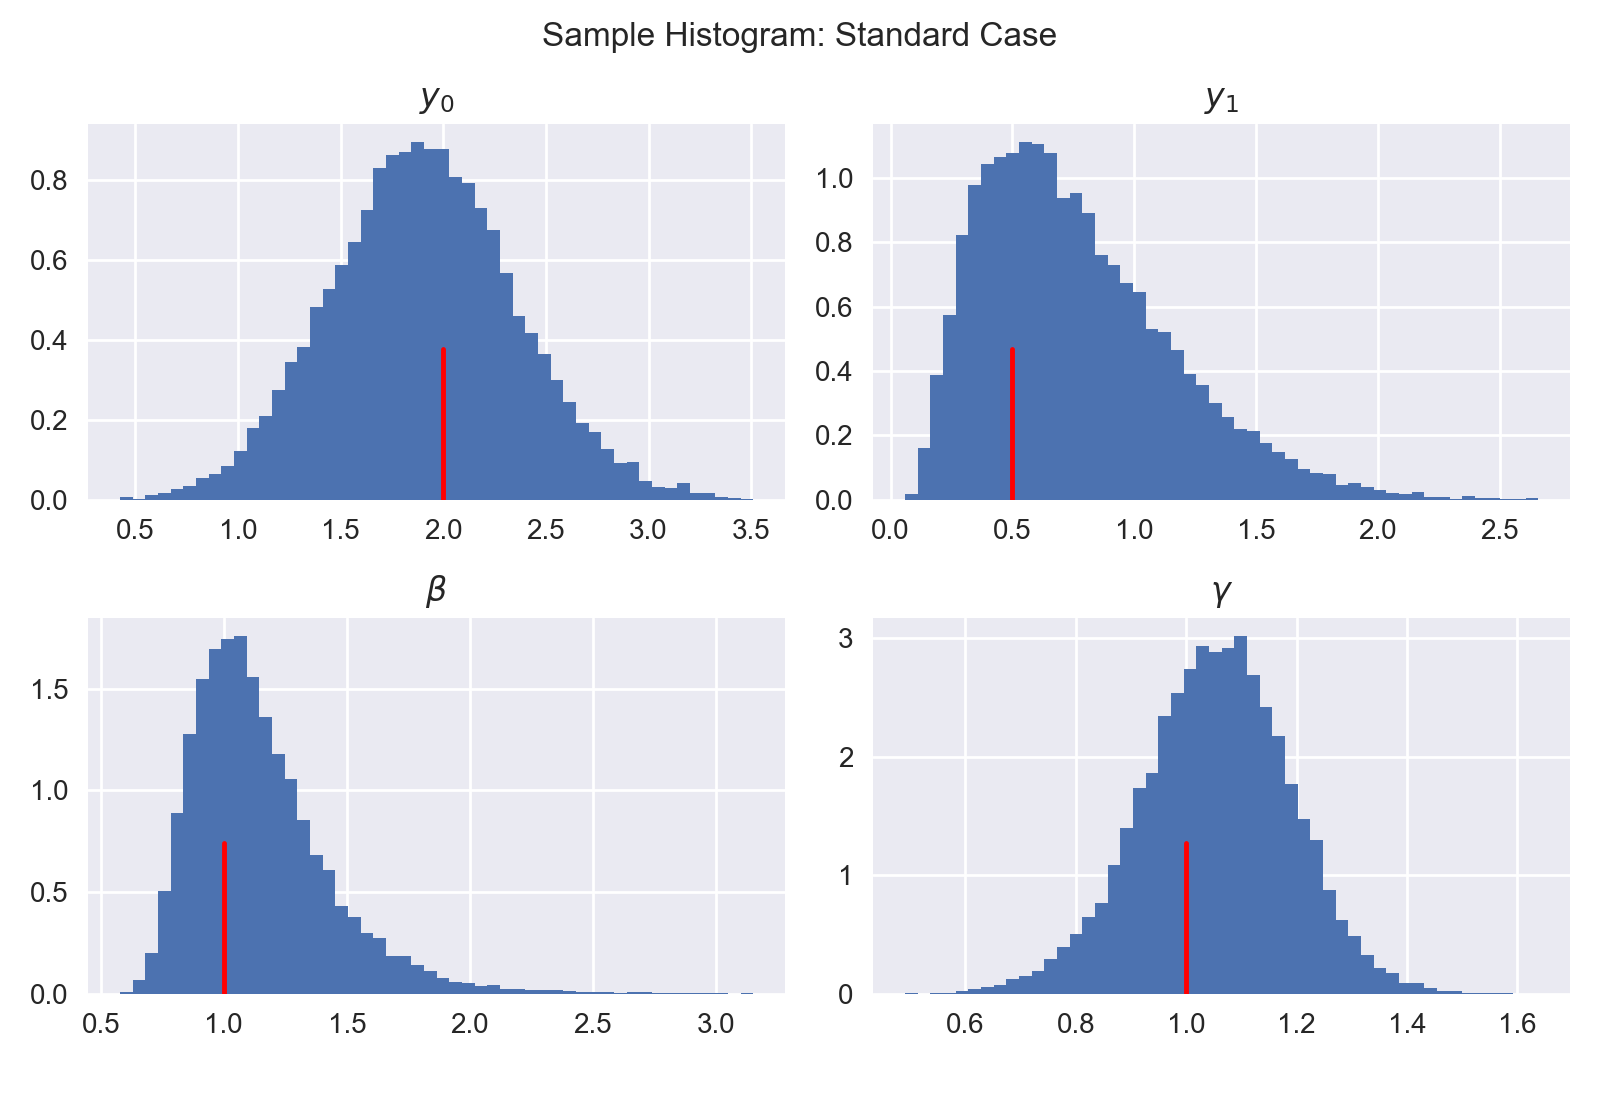

In [28]:
fig = plt.figure()
plt.subplot(2,2,1)
plt.hist(X_std[:,0],bins=50,density=True)
plt.axvline(y0[0],ymax=.4,c='r')
plt.title('$y_0$')

plt.subplot(2,2,2)
plt.hist(X_std[:,1],bins=50,density=True)
plt.axvline(y0[1],ymax=.4,c='r')
plt.title('$y_1$')

plt.subplot(2,2,3)
plt.hist(X_std[:,2],bins=50,density=True)
plt.axvline(b,ymax=.4,c='r')
plt.title('$\\beta$')

plt.subplot(2,2,4)
plt.hist(X_std[:,3],bins=50,density=True)
plt.axvline(c,ymax=.4,c='r')
plt.title('$\\gamma$')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Sample Histogram: Standard Case")
plt.savefig('figures/std_hist.pdf')

## Surrogate data: precision matrix weighting, GP fit to single observation

In [81]:
kernel1 = gp.kernels.ConstantKernel(0.5055,constant_value_bounds="fixed")*gp.kernels.RBF(2.7770**.5,length_scale_bounds='fixed')+gp.kernels.WhiteKernel(0.0909,noise_level_bounds="fixed")
kernel2 = gp.kernels.ConstantKernel(0.4119,constant_value_bounds="fixed")*gp.kernels.RBF(2.2251**.5,length_scale_bounds='fixed')+gp.kernels.WhiteKernel(0.0486,noise_level_bounds="fixed")
y1_gp = gp.GaussianProcessRegressor(kernel1)
y1_gp = y1_gp.fit(T[:,np.newaxis],y_noisy[0].T)
y2_gp = gp.GaussianProcessRegressor(kernel2)
y2_gp = y2_gp.fit(T[:,np.newaxis],y_noisy[1].T)

In [78]:
kernel = gp.kernels.ConstantKernel(0.5055,constant_value_bounds="fixed")*gp.kernels.RBF(2.7770**.5,length_scale_bounds='fixed')+gp.kernels.WhiteKernel(0.0909,noise_level_bounds="fixed")
mygp = gp.GaussianProcessRegressor(kernel)
mygp = mygp.fit(T[:,np.newaxis],y_noisy.T)

In [80]:
mygp.__dict__

{'kernel': 0.711**2 * RBF(length_scale=1.67) + WhiteKernel(noise_level=0.0909),
 'alpha': 1e-10,
 'optimizer': 'fmin_l_bfgs_b',
 'n_restarts_optimizer': 0,
 'normalize_y': False,
 'copy_X_train': True,
 'random_state': None,
 'kernel_': 0.711**2 * RBF(length_scale=1.67) + WhiteKernel(noise_level=0.0909),
 '_rng': RandomState(MT19937) at 0x7FAE25056740,
 'n_features_in_': 1,
 '_y_train_mean': array([0.]),
 '_y_train_std': 1,
 'X_train_': array([[ 0.        ],
        [ 1.11111111],
        [ 2.22222222],
        [ 3.33333333],
        [ 4.44444444],
        [ 5.55555556],
        [ 6.66666667],
        [ 7.77777778],
        [ 8.88888889],
        [10.        ]]),
 'y_train_': array([[2.02977218, 0.50248414],
        [0.99350953, 0.28268093],
        [0.46351541, 0.43186564],
        [0.28855728, 0.85787259],
        [0.42494348, 1.774839  ],
        [1.56646565, 2.1697727 ],
        [2.1801117 , 0.56175893],
        [1.1079175 , 0.29433524],
        [0.51902165, 0.36147151],
        [0

In [57]:
gp.kernels.RBF?

In [82]:
# define high-res time points for evaluation
T_sur = np.linspace(0,10,201)

# compute mean and covariance of GPs
mean1,cov1_gp = y1_gp.predict(T_sur[:,np.newaxis],return_cov=True)
mean2,cov2_gp = y2_gp.predict(T_sur[:,np.newaxis],return_cov=True)

#symmytrize
cov1_gp = .5*(cov1_gp+cov1_gp.T)
cov2_gp = .5*(cov2_gp+cov2_gp.T)

# compute eigendecompositions
e1,v1 = la.eig(cov1_gp)
e2,v2 = la.eig(cov2_gp)

# build weight matrices
W1 = np.real(np.diag(np.sqrt(1/e1))@(v1.T))
W2 = np.real(np.diag(np.sqrt(1/e2))@(v2.T))

# high-resolution true solution
y_hr = solve_lv(T_sur,y0,a,b,c,d)

In [87]:
from scipy.io import loadmat

W1_mat = loadmat('W1.mat')['tmp']
W2_mat = loadmat('W2.mat')['tmp']

In [88]:
W1_mat

array([[ 0.00268037,  0.03835856, -0.08227512, ..., -0.02813153,
         0.02243342, -0.00614241],
       [-0.01388417,  0.05196195,  0.0652104 , ..., -0.11487091,
         0.00270243, -0.01457347],
       [ 0.09269531, -0.11447239,  0.07180645, ...,  0.11664188,
        -0.00143531,  0.02877082],
       ...,
       [-0.17170184,  0.39553222, -0.31634511, ..., -0.41523113,
         0.26277806, -0.10543076],
       [-0.07857675,  0.1202344 , -0.03941176, ...,  0.21586767,
        -0.1456936 ,  0.04694225],
       [-0.07370276,  0.16208711,  0.00106167, ...,  0.23679178,
        -0.30357078,  0.1033669 ]])

<IPython.core.display.Javascript object>


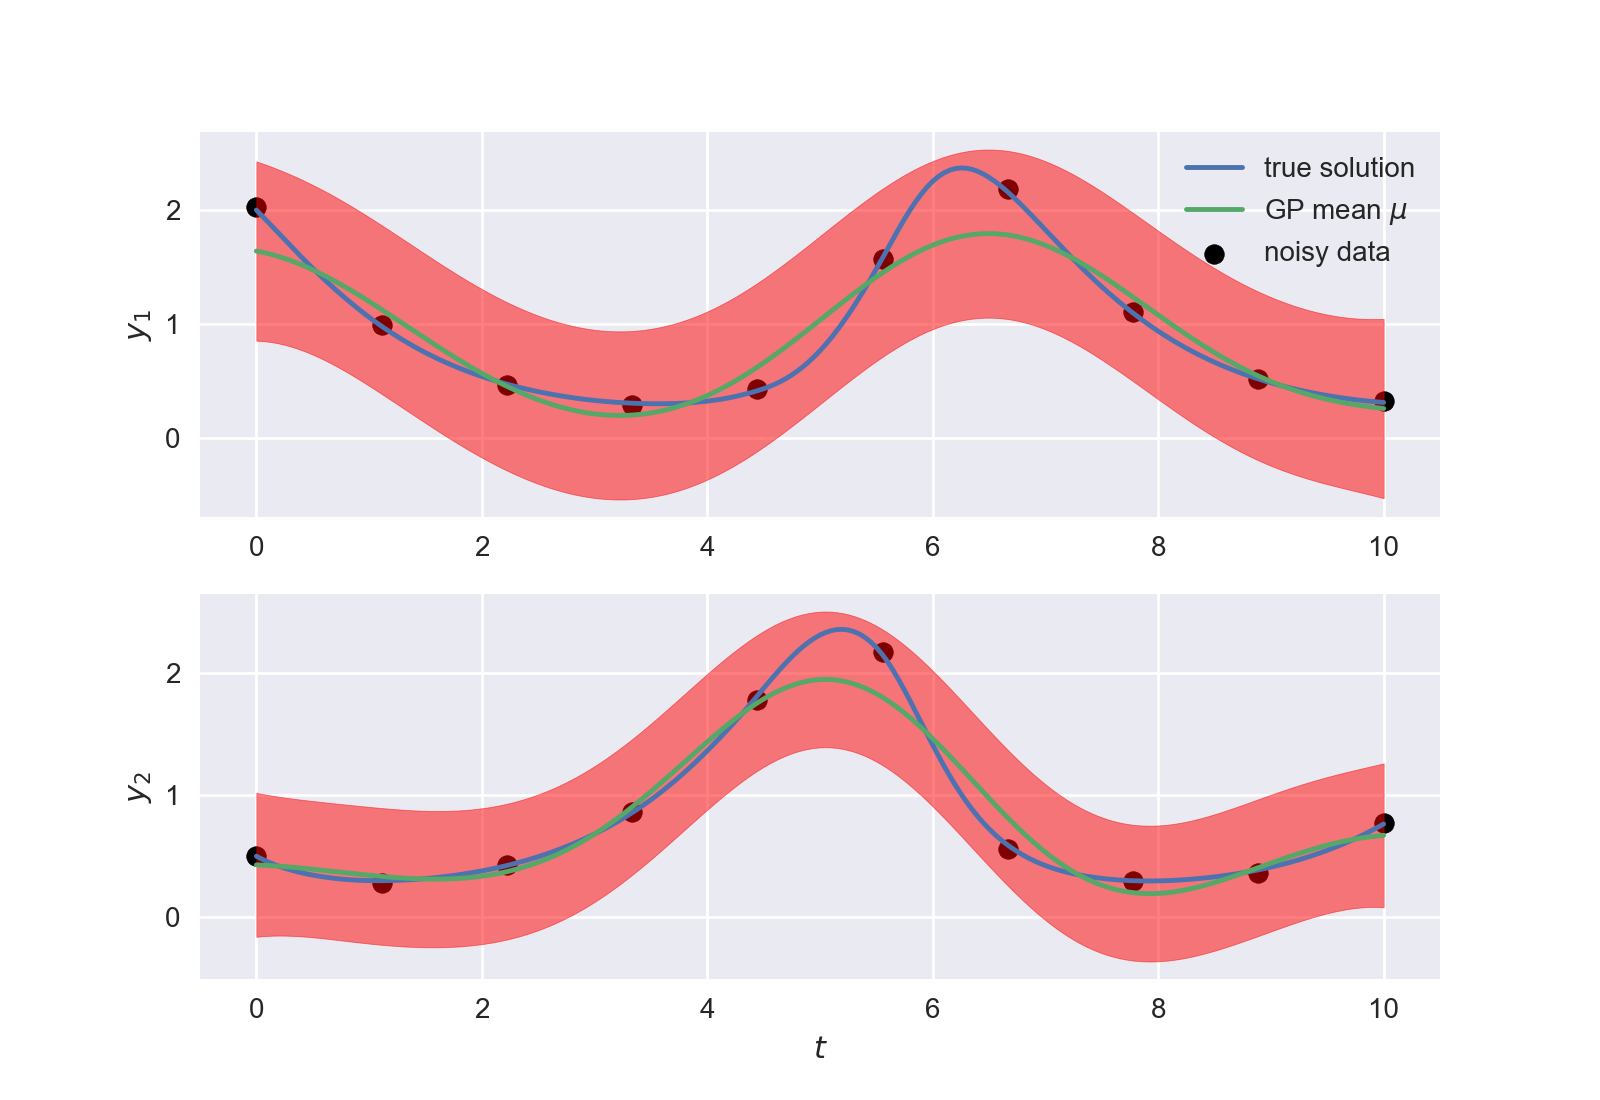

In [61]:
fig = plt.figure()
plt.subplot(211)
plt.ylabel('$y_1$')
plt.plot(T_sur,y_hr[0],label='true solution')
plt.scatter(T,y_noisy[0],c='k',label='noisy data')
plt.plot(T_sur,mean1,label='GP mean $\mu$')
plt.fill_between(T_sur,mean1-2*np.sqrt(np.diag(cov1_gp)),mean1+2*np.sqrt(np.diag(cov1_gp)),color='r',alpha=.5)
plt.legend()
plt.subplot(212)
plt.ylabel('$y_2$')
plt.xlabel('$t$')
plt.plot(T_sur,y_hr[1],label='true')
plt.scatter(T,y_noisy[1],c='k',label='noisy')
plt.plot(T_sur,mean2,label='GP')
plt.fill_between(T_sur,mean2-2*np.sqrt(np.diag(cov2_gp)),mean2+2*np.sqrt(np.diag(cov2_gp)),color='r',alpha=.5)
plt.savefig('figures/surrogate.pdf')

In [89]:
# define likelihood and prior
# gaussian likelihood
def llh_sur1(y):
    return -la.norm(W1_mat@(y[0]-mean[:,0]))**2 - la.norm(W2_mat@(y[1]-mean[:,1]))**2

# uniform prior
def lpr_sur(x):
    if np.all((0<x)&(x<10)):
        return 0
    else:
        return np.NINF
    
# define forward model
def f_sur(x):
    return solve_lv(T_sur,x[:2],1,x[2],x[3],1)

In [90]:
# sample
cov = .002*np.eye(4)
X_sur1 = rw_metropolis_hastings(f_sur,llh_sur1,lpr_sur,cov,x0,n=10000,burn_in=1000,update=False,verbose=True)

kdes_sur1 = []
for col in X_sur1.T:
    kdes_sur1.append(gaussian_kde(col))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
acceptance rate: 0.1848


<IPython.core.display.Javascript object>


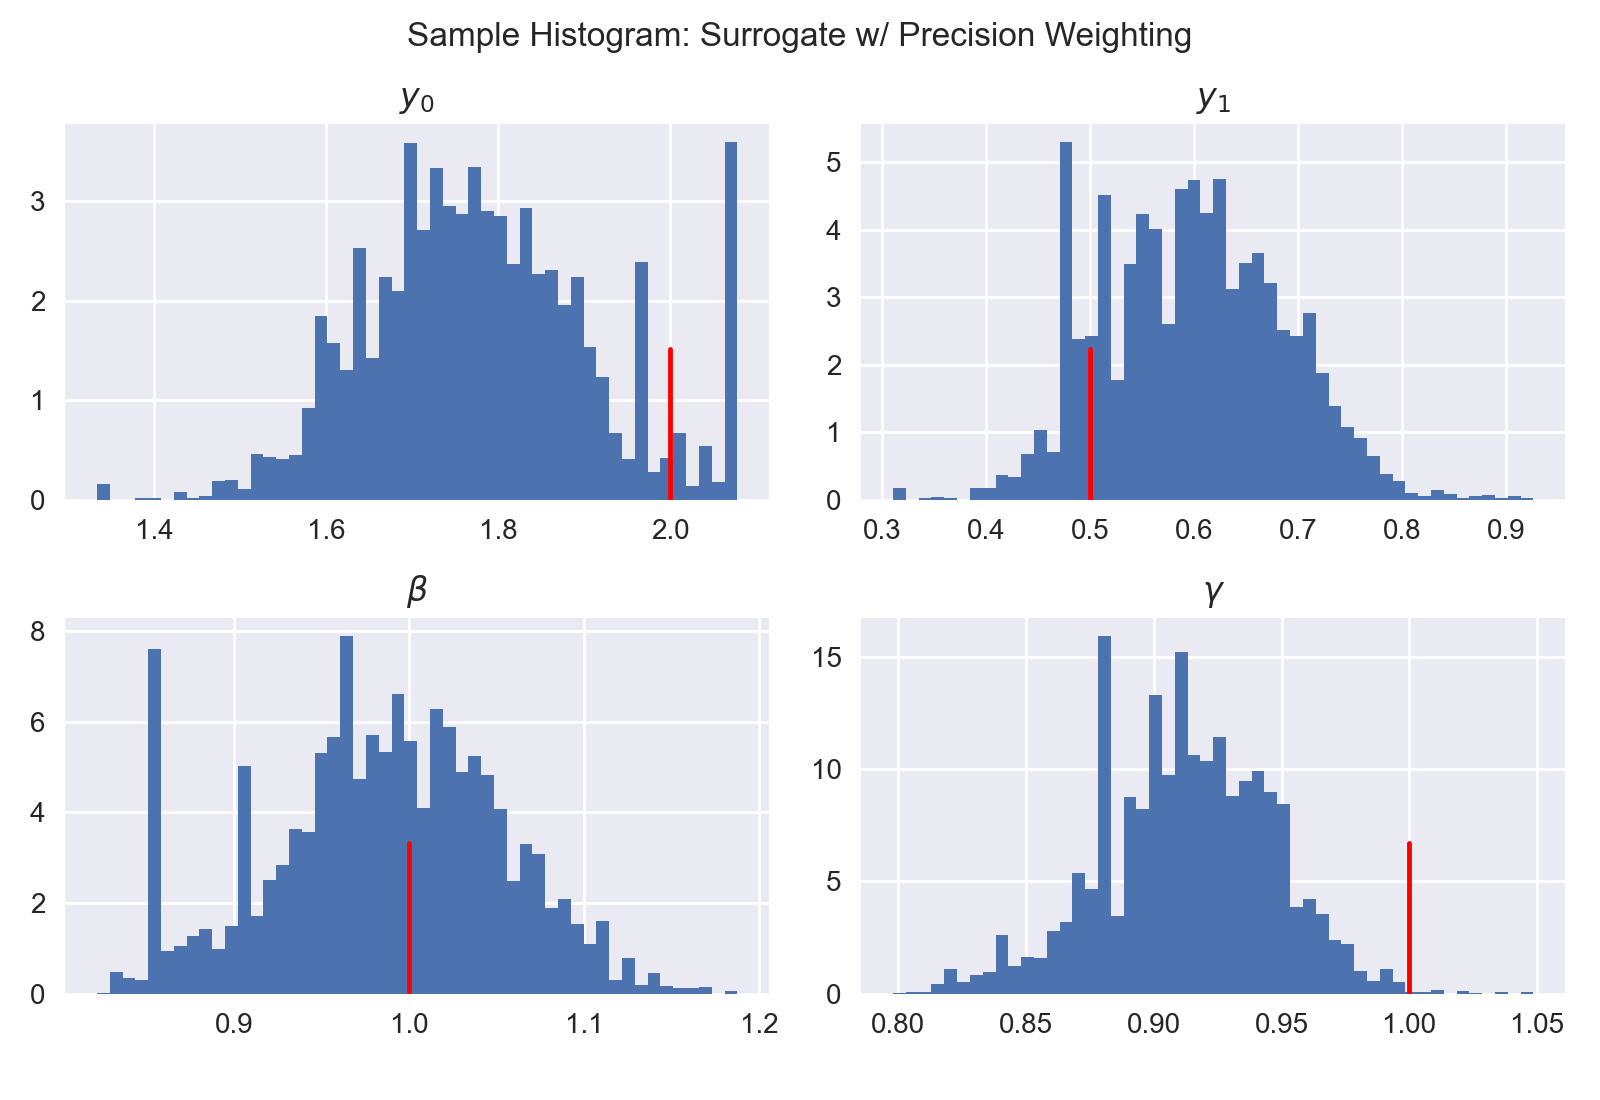

In [91]:
fig = plt.figure()
plt.subplot(2,2,1)
plt.hist(X_sur1[:,0],bins=50,density=True)
plt.axvline(y0[0],ymax=.4,c='r')
plt.title('$y_0$')

plt.subplot(2,2,2)
plt.hist(X_sur1[:,1],bins=50,density=True)
plt.axvline(y0[1],ymax=.4,c='r')
plt.title('$y_1$')

plt.subplot(2,2,3)
plt.hist(X_sur1[:,2],bins=50,density=True)
plt.axvline(b,ymax=.4,c='r')
plt.title('$\\beta$')

plt.subplot(2,2,4)
plt.hist(X_sur1[:,3],bins=50,density=True)
plt.axvline(c,ymax=.4,c='r')
plt.title('$\\gamma$')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Sample Histogram: Surrogate w/ Precision Weighting")
plt.savefig('figures/sur1_hist.pdf')

<IPython.core.display.Javascript object>


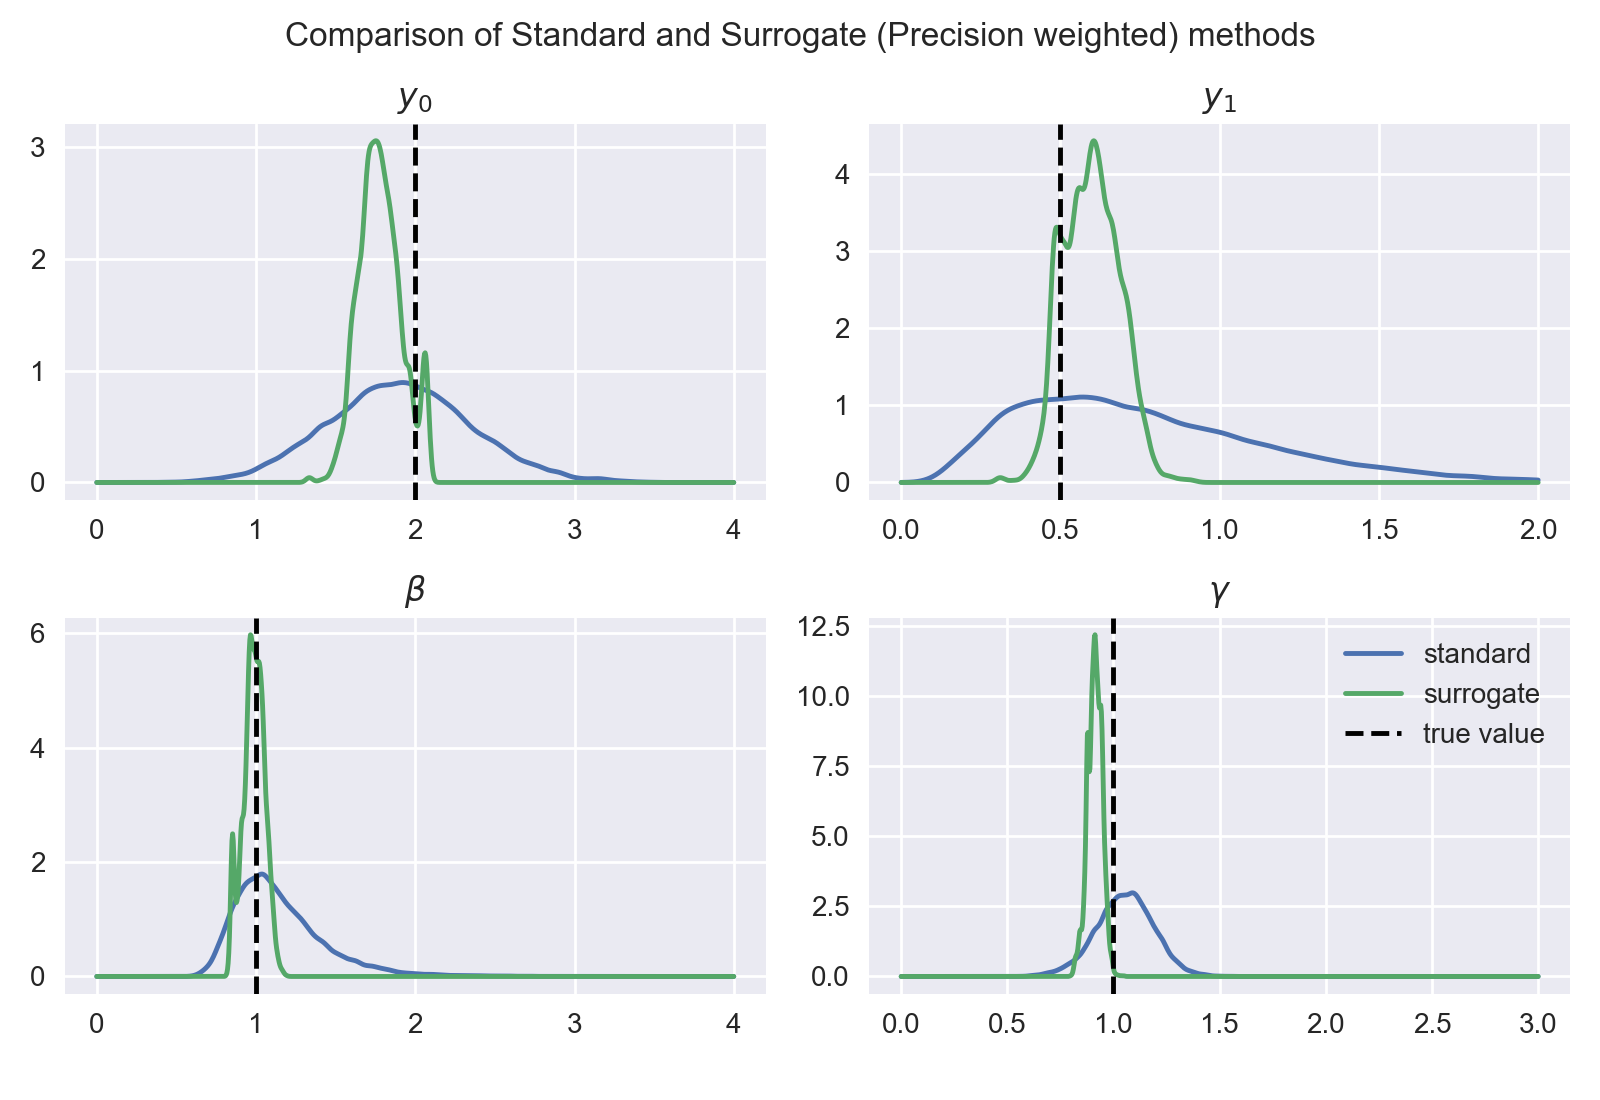

In [92]:
fig = plt.figure()
# y_o
plt.subplot(221)
x = np.linspace(0,4,1000)
plt.plot(x,kdes_std[0].pdf(x),label='standard')
plt.plot(x,kdes_sur1[0].pdf(x),label='surrogate')
plt.axvline(2,ls='--',c='k')
plt.title("$y_0$")

# y_1
plt.subplot(222)
x = np.linspace(0,2,1000)
plt.plot(x,kdes_std[1].pdf(x),label='standard')
plt.plot(x,kdes_sur1[1].pdf(x),label='surrogate')
plt.axvline(.5,ls='--',c='k')
plt.title("$y_1$")

# beta
plt.subplot(223)
x = np.linspace(0,4,1000)
plt.plot(x,kdes_std[2].pdf(x),label='standard')
plt.plot(x,kdes_sur1[2].pdf(x),label='surrogate')
plt.axvline(1,ls='--',c='k')
plt.title("$\\beta$")

# gamma
plt.subplot(224)
x = np.linspace(0,3,1000)
plt.plot(x,kdes_std[3].pdf(x),label='standard')
plt.plot(x,kdes_sur1[3].pdf(x),label='surrogate')
plt.axvline(1,ls='--',c='k',label='true value')
plt.title("$\\gamma$")


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Comparison of Standard and Surrogate (Precision weighted) methods")
plt.legend()
plt.savefig('figures/sur1_kdes.pdf')

In [34]:
# sample
cov = .002*np.eye(4)
X_sur3 = rw_metropolis_hastings(f_sur,llh_sur1,lpr_sur,cov,np.array([y0[0],y0[1],b,c]),n=100000,burn_in=10000,update=False,verbose=True)

kdes_sur3 = []
for col in X_sur3.T:
    kdes_sur3.append(gaussian_kde(col))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
acceptance rate: 0.15924


<IPython.core.display.Javascript object>


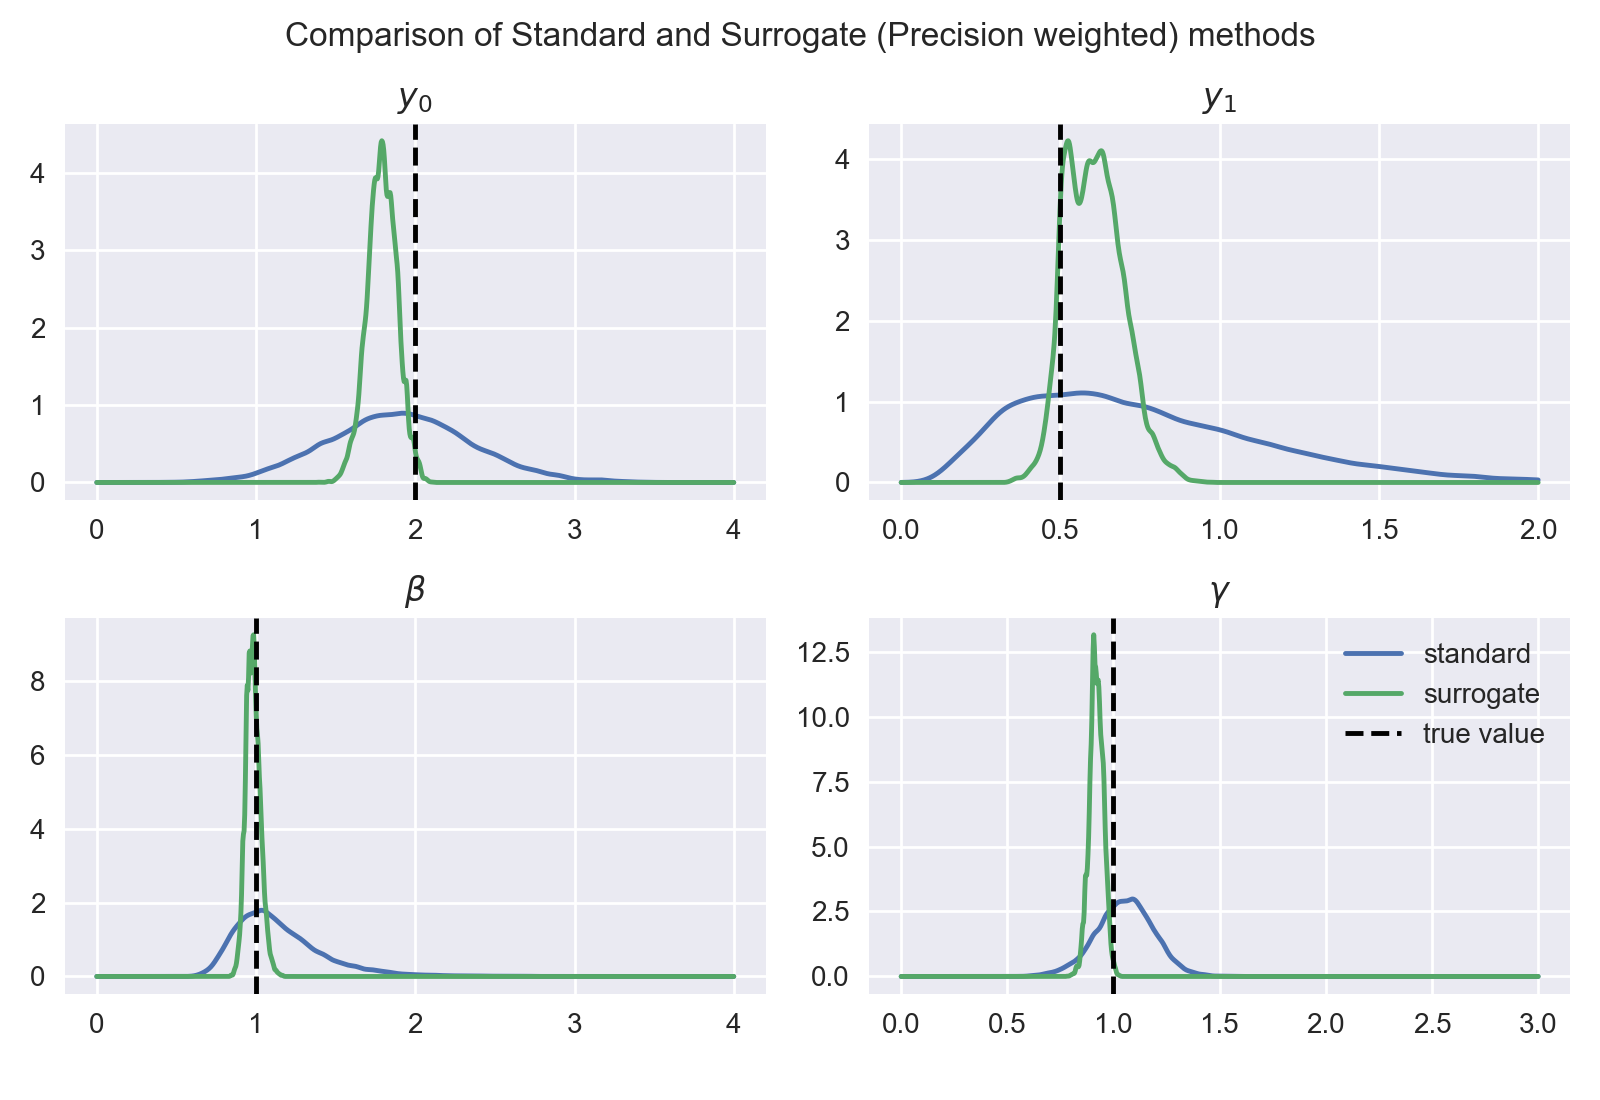

In [35]:
fig = plt.figure()
# y_o
plt.subplot(221)
x = np.linspace(0,4,1000)
plt.plot(x,kdes_std[0].pdf(x),label='standard')
plt.plot(x,kdes_sur3[0].pdf(x),label='surrogate')
plt.axvline(2,ls='--',c='k')
plt.title("$y_0$")

# y_1
plt.subplot(222)
x = np.linspace(0,2,1000)
plt.plot(x,kdes_std[1].pdf(x),label='standard')
plt.plot(x,kdes_sur3[1].pdf(x),label='surrogate')
plt.axvline(.5,ls='--',c='k')
plt.title("$y_1$")

# beta
plt.subplot(223)
x = np.linspace(0,4,1000)
plt.plot(x,kdes_std[2].pdf(x),label='standard')
plt.plot(x,kdes_sur3[2].pdf(x),label='surrogate')
plt.axvline(1,ls='--',c='k')
plt.title("$\\beta$")

# gamma
plt.subplot(224)
x = np.linspace(0,3,1000)
plt.plot(x,kdes_std[3].pdf(x),label='standard')
plt.plot(x,kdes_sur3[3].pdf(x),label='surrogate')
plt.axvline(1,ls='--',c='k',label='true value')
plt.title("$\\gamma$")


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Comparison of Standard and Surrogate (Precision weighted) methods")
plt.legend()
plt.savefig('figures/sur1_kdes.pdf')

## Surrogate:  no precision matrix weighting

In [62]:
# build GP with same parameters but no white noise
# check parameters
print(y_gp.kernel_)

1.07**2 * RBF(length_scale=1.65) + WhiteKernel(noise_level=0.0469)


In [64]:
kernel2 = gp.kernels.ConstantKernel(1.23**2,constant_value_bounds="fixed")*gp.kernels.RBF(length_scale=1.47, length_scale_bounds="fixed")
y_gp2 = gp.GaussianProcessRegressor(kernel2)
y_gp2 = y_gp2.fit(T[:,np.newaxis],y_noisy.T)

mean2 = y_gp2.predict(T_sur[:,np.newaxis])

In [40]:
nsamp = 10
samples = y_gp2.sample_y(T_sur[:,np.newaxis],10)

NameError: name 'y_gp2' is not defined

<IPython.core.display.Javascript object>


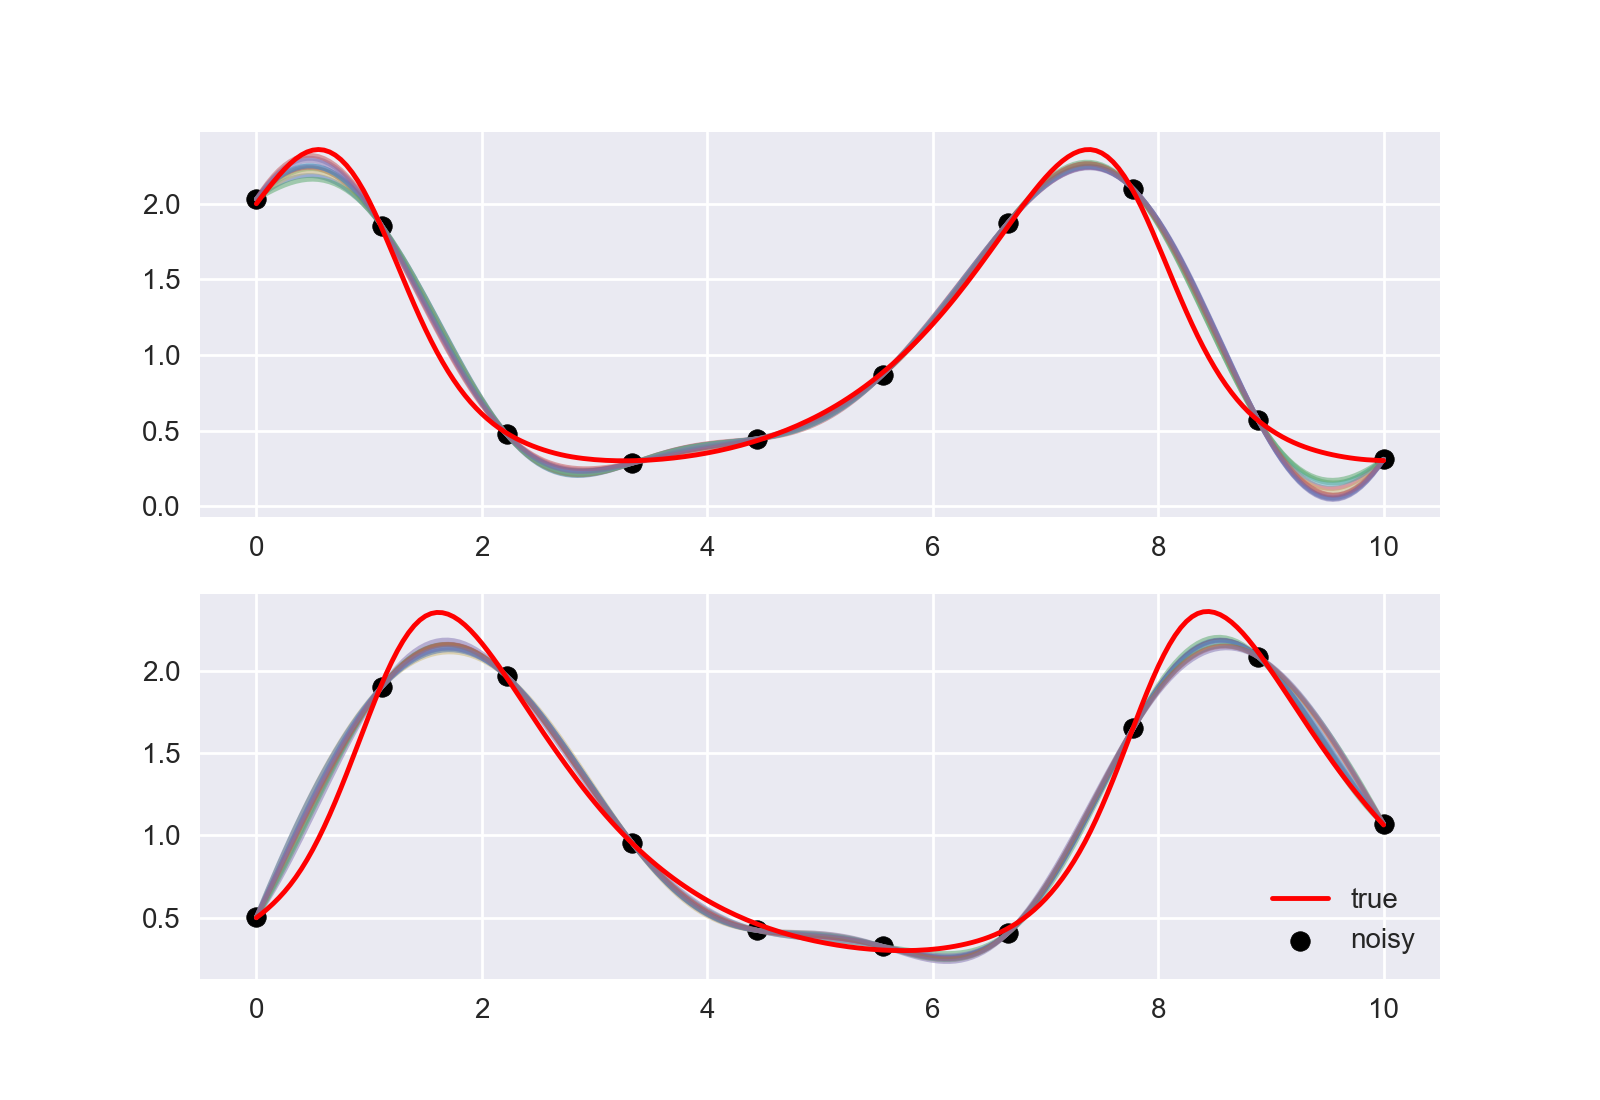

In [111]:
fig = plt.figure()
plt.subplot(211)
plt.plot(T_sur,samples[:,0],alpha=.5)
plt.plot(T_sur,y_hr[0],c='r',label='true')
plt.scatter(T,y_noisy[0],c='k',label='noisy')

plt.subplot(212)
plt.plot(T_sur,samples[:,1],alpha=.5)
plt.plot(T_sur,y_hr[1],c='r',label='true')
plt.scatter(T,y_noisy[1],c='k',label='noisy')
plt.legend()
plt.savefig('figures/gp_samples.pdf')

In [68]:
def llh_sur2(y):
    return -((y-mean2.T)**2).sum()

In [72]:
# sample
cov = .002*np.eye(4)
X_sur2 = rw_metropolis_hastings(f_sur,llh_sur2,lpr_sur,cov,x0,n=100000,burn_in=10000,update=False,verbose=True)

kdes_sur2 = []
for col in X_sur2.T:
    kdes_sur2.append(gaussian_kde(col))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
acceptance rate: 0.22576


<IPython.core.display.Javascript object>


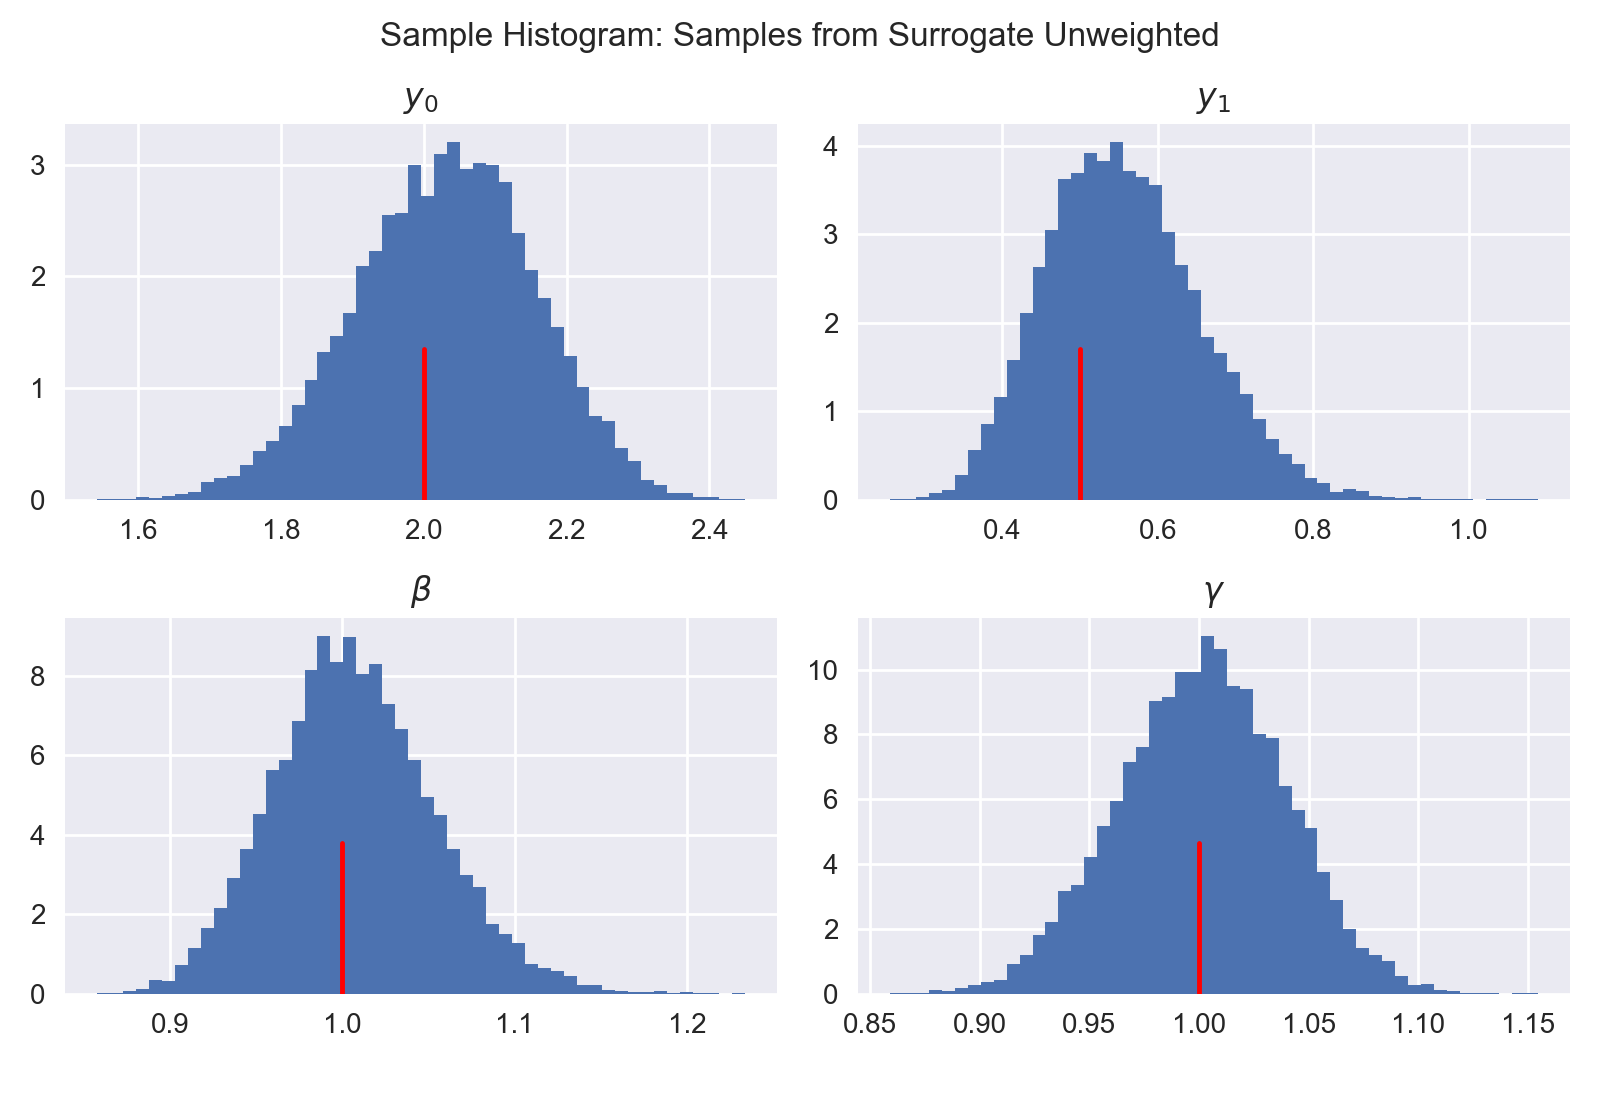

In [73]:
fig = plt.figure()
plt.subplot(2,2,1)
plt.hist(X_sur2[:,0],bins=50,density=True)
plt.axvline(y0[0],ymax=.4,c='r')
plt.title('$y_0$')

plt.subplot(2,2,2)
plt.hist(X_sur2[:,1],bins=50,density=True)
plt.axvline(y0[1],ymax=.4,c='r')
plt.title('$y_1$')

plt.subplot(2,2,3)
plt.hist(X_sur2[:,2],bins=50,density=True)
plt.axvline(b,ymax=.4,c='r')
plt.title('$\\beta$')

plt.subplot(2,2,4)
plt.hist(X_sur2[:,3],bins=50,density=True)
plt.axvline(c,ymax=.4,c='r')
plt.title('$\\gamma$')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Sample Histogram: Samples from Surrogate Unweighted")
plt.savefig('figures/sur2_hist.pdf')

<IPython.core.display.Javascript object>


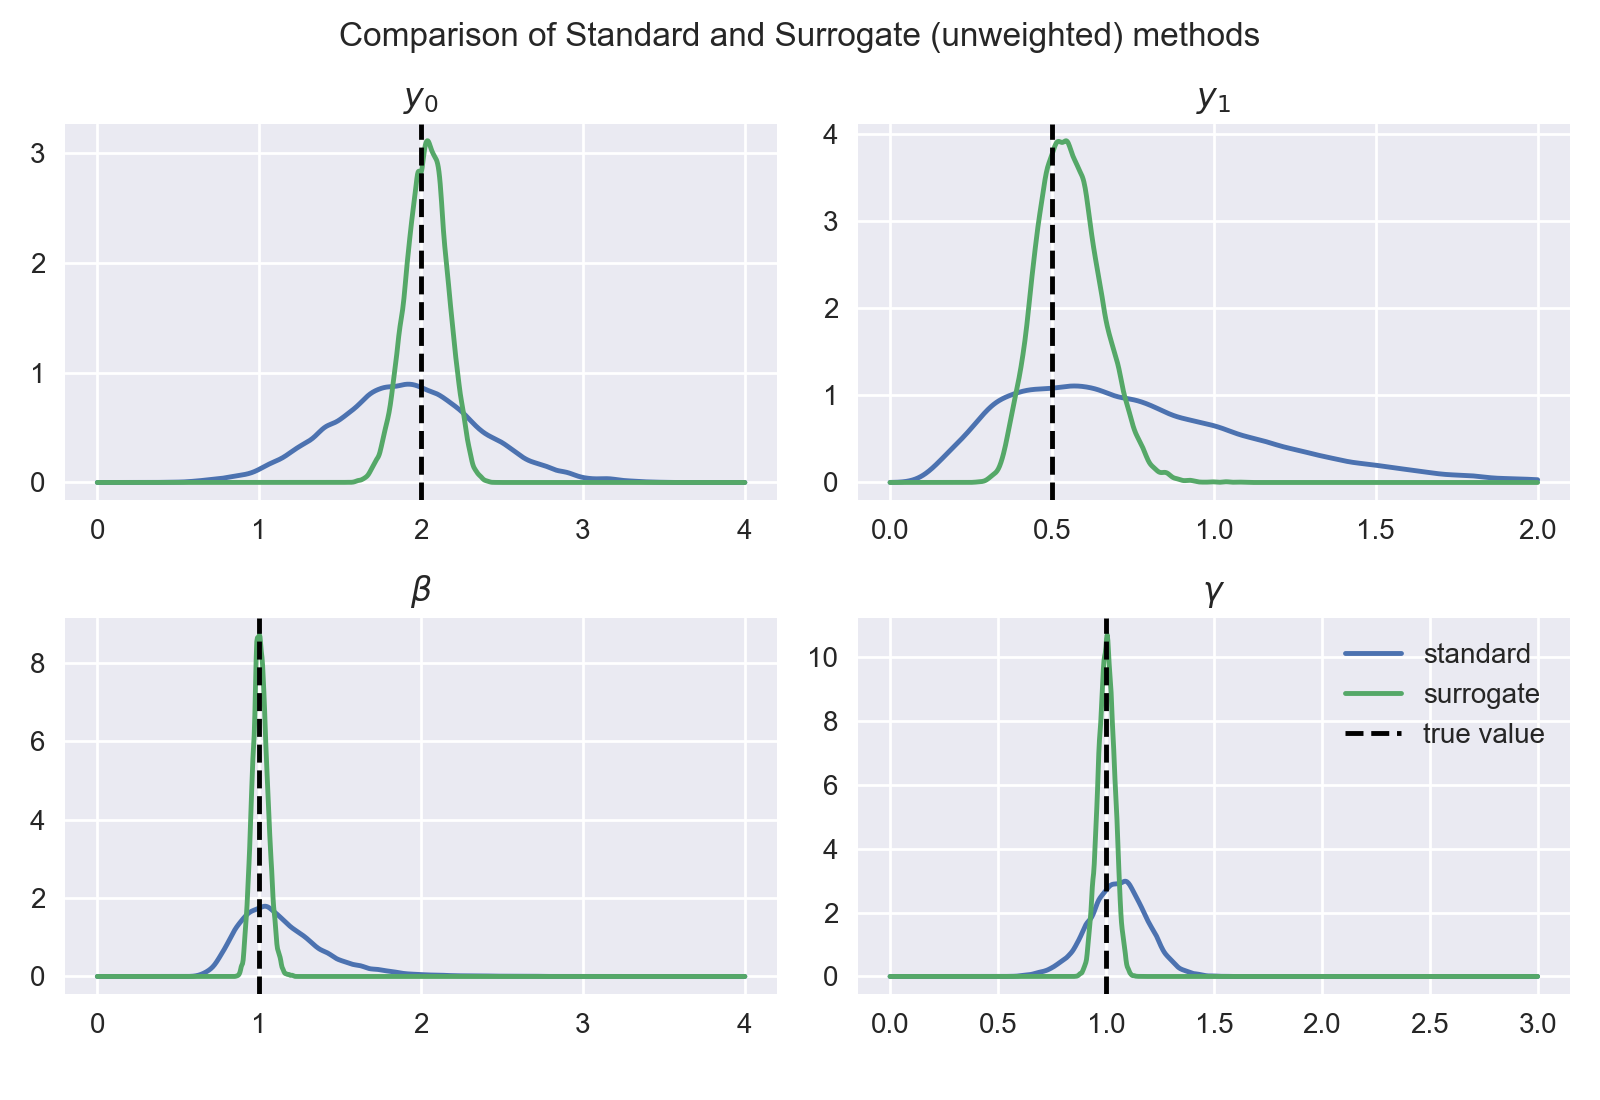

In [74]:
fig = plt.figure()
# y_o
plt.subplot(221)
x = np.linspace(0,4,1000)
plt.plot(x,kdes_std[0].pdf(x),label='standard')
plt.plot(x,kdes_sur2[0].pdf(x),label='surrogate')
plt.axvline(2,ls='--',c='k')
plt.title("$y_0$")

# y_1
plt.subplot(222)
x = np.linspace(0,2,1000)
plt.plot(x,kdes_std[1].pdf(x),label='standard')
plt.plot(x,kdes_sur2[1].pdf(x),label='surrogate')
plt.axvline(.5,ls='--',c='k')
plt.title("$y_1$")

# beta
plt.subplot(223)
x = np.linspace(0,4,1000)
plt.plot(x,kdes_std[2].pdf(x),label='standard')
plt.plot(x,kdes_sur2[2].pdf(x),label='surrogate')
plt.axvline(1,ls='--',c='k')
plt.title("$\\beta$")

# gamma
plt.subplot(224)
x = np.linspace(0,3,1000)
plt.plot(x,kdes_std[3].pdf(x),label='standard')
plt.plot(x,kdes_sur2[3].pdf(x),label='surrogate')
plt.axvline(1,ls='--',c='k',label='true value')
plt.title("$\\gamma$")


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Comparison of Standard and Surrogate (unweighted) methods")
plt.legend()
plt.savefig('figures/sur2_kdes.pdf')

## Gridsearch to validate posteriors

In [45]:
# gridsearch
import time

n = 20
y0_ = np.linspace(1.5,2.5,n)
y1_ = np.linspace(.25,.75,n)
beta_ = np.linspace(.75,1.25,n)
gamma_ = np.linspace(.75,1.25,n)
LLH_std = np.empty((n,n,n,n))
LLH_sur1 = np.empty((n,n,n,n))
# LLH_sur2 = np.empty((n,n,n,n))
start = time.time()
for i in range(len(y0_)):
    print(f"i={i}")
    for j in range(len(y1_)):
        for k in range(len(beta_)):
            for l in range(len(gamma_)):
                u = f_std([y0_[i],y1_[j],beta_[k],gamma_[l]])
                LLH_std[i,j,k,l] = llh_std(u)
                u = f_sur([y0_[i],y1_[j],beta_[k],gamma_[l]])
                LLH_sur1[i,j,k,l] = llh_sur1(u)
#                 LLH_sur2[i,j,k,l] = llh_sur2(u)
end = time.time()
print('Runtime:',end-start)
print('Time per sample:',(end-start)/LLH_std.size)

                
# compute probability densities
pdf_std = np.exp(LLH_std)
pdf_sur1 = np.exp(LLH_sur1)
# pdf_sur2 = np.exp(LLH_sur2)

i=0
i=1
i=2
i=3
i=4
i=5
i=6
i=7
i=8
i=9
i=10
i=11
i=12
i=13
i=14
i=15
i=16
i=17
i=18
i=19
Runtime: 695.7744469642639
Time per sample: 0.0043485902935266494


<IPython.core.display.Javascript object>


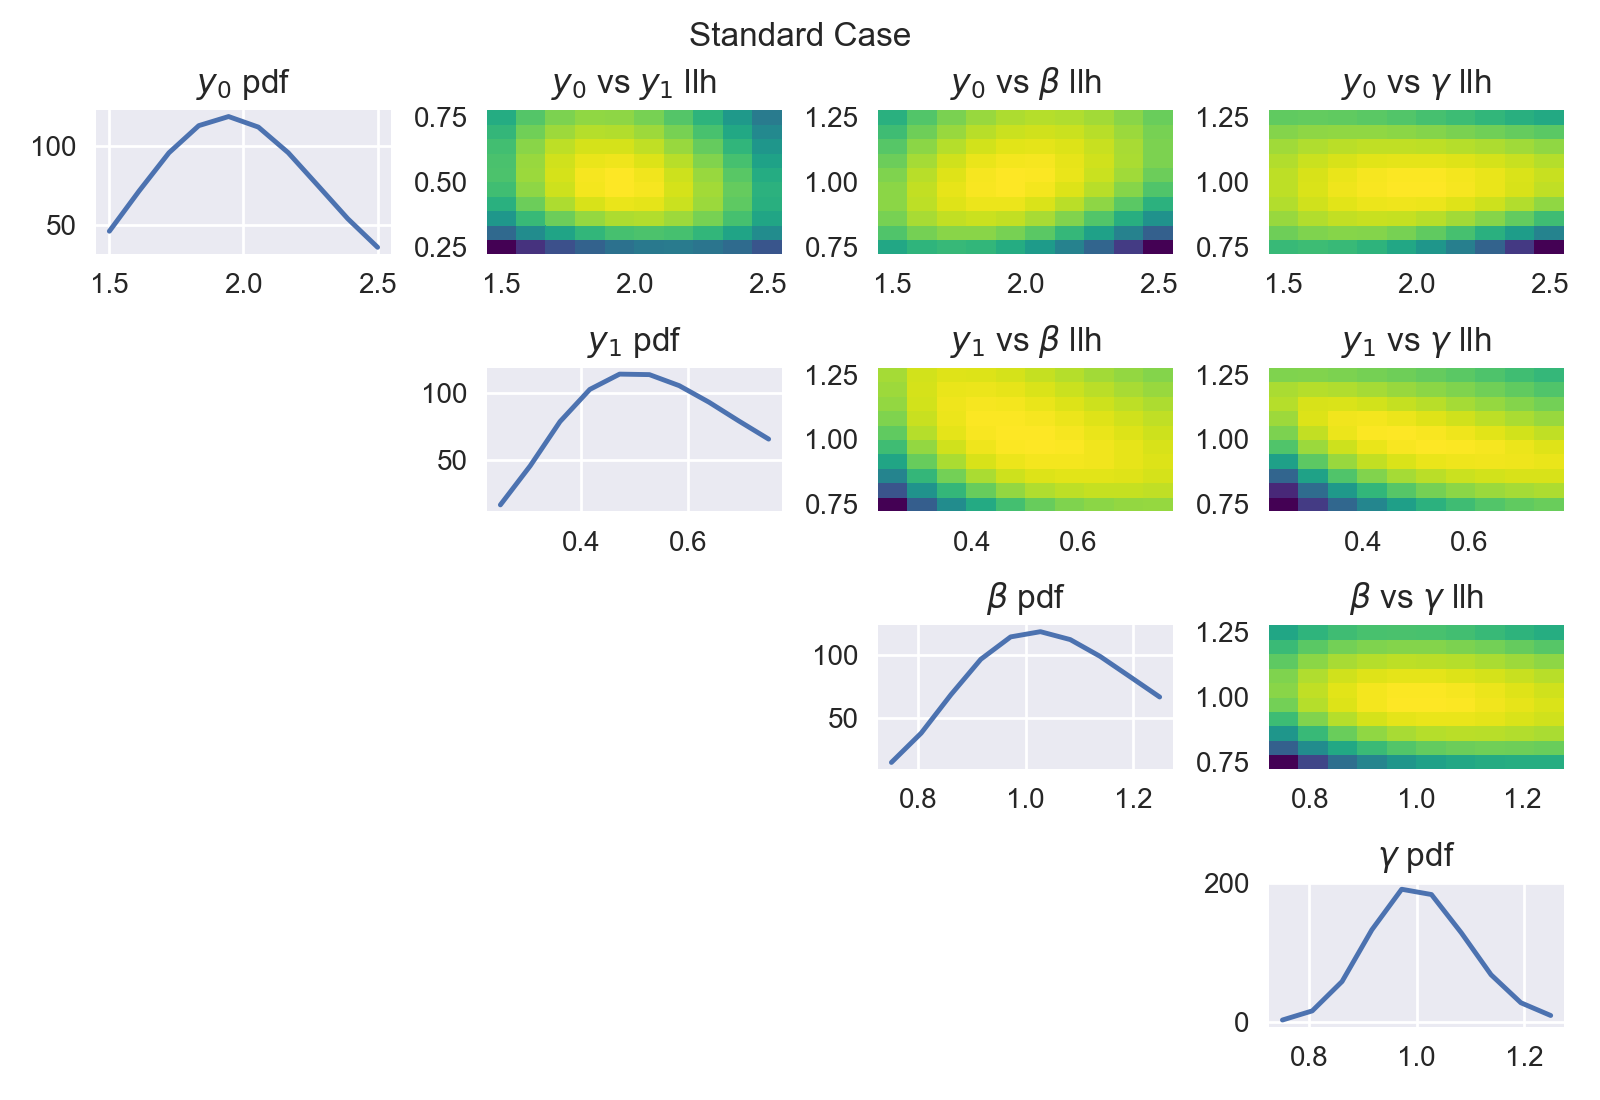

In [91]:
data = pdf_std

fig = plt.figure()
plt.subplot(441)
plt.plot(y0_,data.sum(axis=(1,2,3)))
plt.title('$y_0$ pdf')
plt.subplot(442)
X,Y = np.meshgrid(y0_,y1_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(2,3))),cmap='viridis',shading='auto')
plt.title('$y_0$ vs $y_1$ llh')
plt.subplot(443)
X,Y = np.meshgrid(y0_,beta_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(1,3))),cmap='viridis',shading='auto')
plt.title('$y_0$ vs $\\beta$ llh')
plt.subplot(444)
X,Y = np.meshgrid(y0_,gamma_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(1,2))),cmap='viridis',shading='auto')
plt.title('$y_0$ vs $\\gamma$ llh')

plt.subplot(446)
plt.plot(y1_,data.sum(axis=(0,2,3)))
plt.title('$y_1$ pdf')
plt.subplot(447)
X,Y = np.meshgrid(y1_,beta_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,3))),cmap='viridis',shading='auto')
plt.title('$y_1$ vs $\\beta$ llh')
plt.subplot(448)
X,Y = np.meshgrid(y1_,gamma_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,2))),cmap='viridis',shading='auto')
plt.title('$y_1$ vs $\\gamma$ llh')

plt.subplot(4,4,11)
plt.plot(beta_,data.sum(axis=(0,1,3)))
plt.title('$\\beta$ pdf')
plt.subplot(4,4,12)
X,Y = np.meshgrid(beta_,gamma_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,1))),cmap='viridis',shading='auto')
plt.title('$\\beta$ vs $\\gamma$ llh')

plt.subplot(4,4,16)
plt.plot(gamma_,data.sum(axis=(0,1,2)))
plt.title('$\\gamma$ pdf')

plt.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle("Standard Case")
plt.show()

<IPython.core.display.Javascript object>


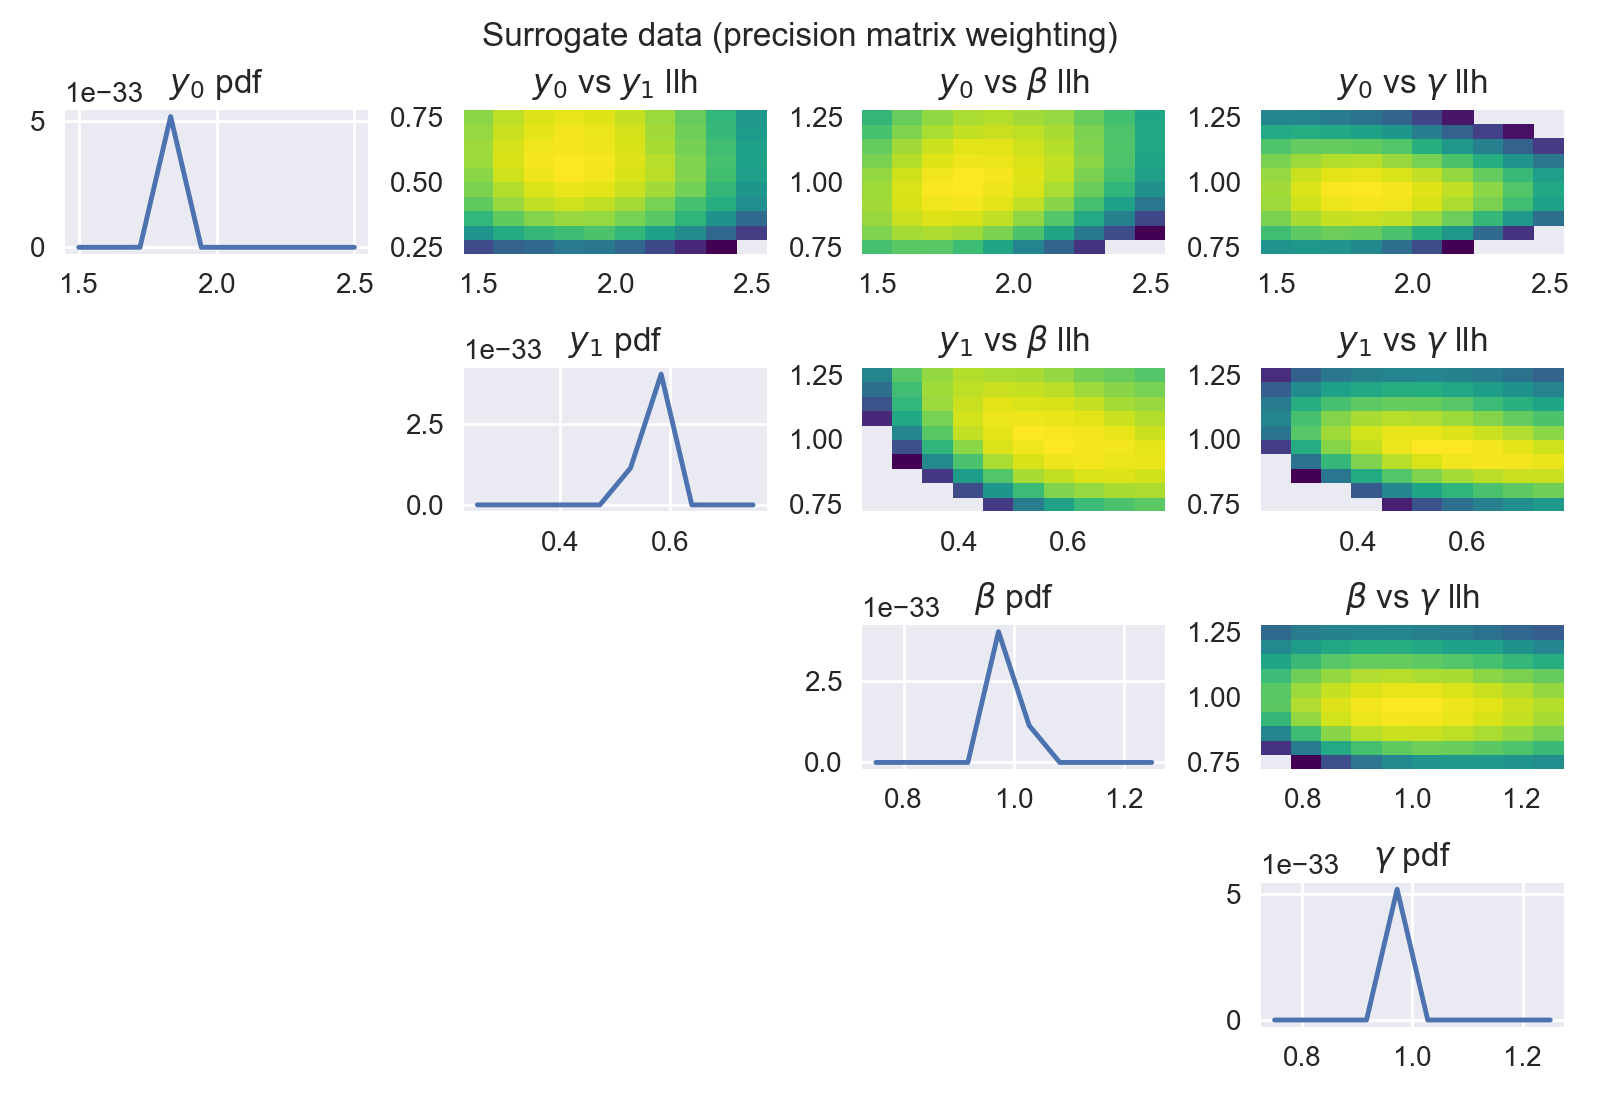

<ipython-input-92-fbf9a51ed0b9>:9: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(X,Y,np.log(data.sum(axis=(2,3))),cmap='viridis',shading='auto')
<ipython-input-92-fbf9a51ed0b9>:13: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(X,Y,np.log(data.sum(axis=(1,3))),cmap='viridis',shading='auto')
<ipython-input-92-fbf9a51ed0b9>:17: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(X,Y,np.log(data.sum(axis=(1,2))),cmap='viridis',shading='auto')
<ipython-input-92-fbf9a51ed0b9>:25: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,3))),cmap='viridis',shading='auto')
<ipython-input-92-fbf9a51ed0b9>:29: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,2))),cmap='viridis',shading='auto')
<ipython-input-92-fbf9a51ed0b9>:37: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,1))),cmap='viridis',shading='auto')

In [92]:
data = pdf_sur1

fig = plt.figure()
plt.subplot(441)
plt.plot(y0_,data.sum(axis=(1,2,3)))
plt.title('$y_0$ pdf')
plt.subplot(442)
X,Y = np.meshgrid(y0_,y1_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(2,3))),cmap='viridis',shading='auto')
plt.title('$y_0$ vs $y_1$ llh')
plt.subplot(443)
X,Y = np.meshgrid(y0_,beta_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(1,3))),cmap='viridis',shading='auto')
plt.title('$y_0$ vs $\\beta$ llh')
plt.subplot(444)
X,Y = np.meshgrid(y0_,gamma_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(1,2))),cmap='viridis',shading='auto')
plt.title('$y_0$ vs $\\gamma$ llh')

plt.subplot(446)
plt.plot(y1_,data.sum(axis=(0,2,3)))
plt.title('$y_1$ pdf')
plt.subplot(447)
X,Y = np.meshgrid(y1_,beta_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,3))),cmap='viridis',shading='auto')
plt.title('$y_1$ vs $\\beta$ llh')
plt.subplot(448)
X,Y = np.meshgrid(y1_,gamma_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,2))),cmap='viridis',shading='auto')
plt.title('$y_1$ vs $\\gamma$ llh')

plt.subplot(4,4,11)
plt.plot(beta_,data.sum(axis=(0,1,3)))
plt.title('$\\beta$ pdf')
plt.subplot(4,4,12)
X,Y = np.meshgrid(beta_,gamma_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,1))),cmap='viridis',shading='auto')
plt.title('$\\beta$ vs $\\gamma$ llh')

plt.subplot(4,4,16)
plt.plot(gamma_,data.sum(axis=(0,1,2)))
plt.title('$\\gamma$ pdf')

plt.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle("Surrogate data (precision matrix weighting)")
plt.show()

<IPython.core.display.Javascript object>


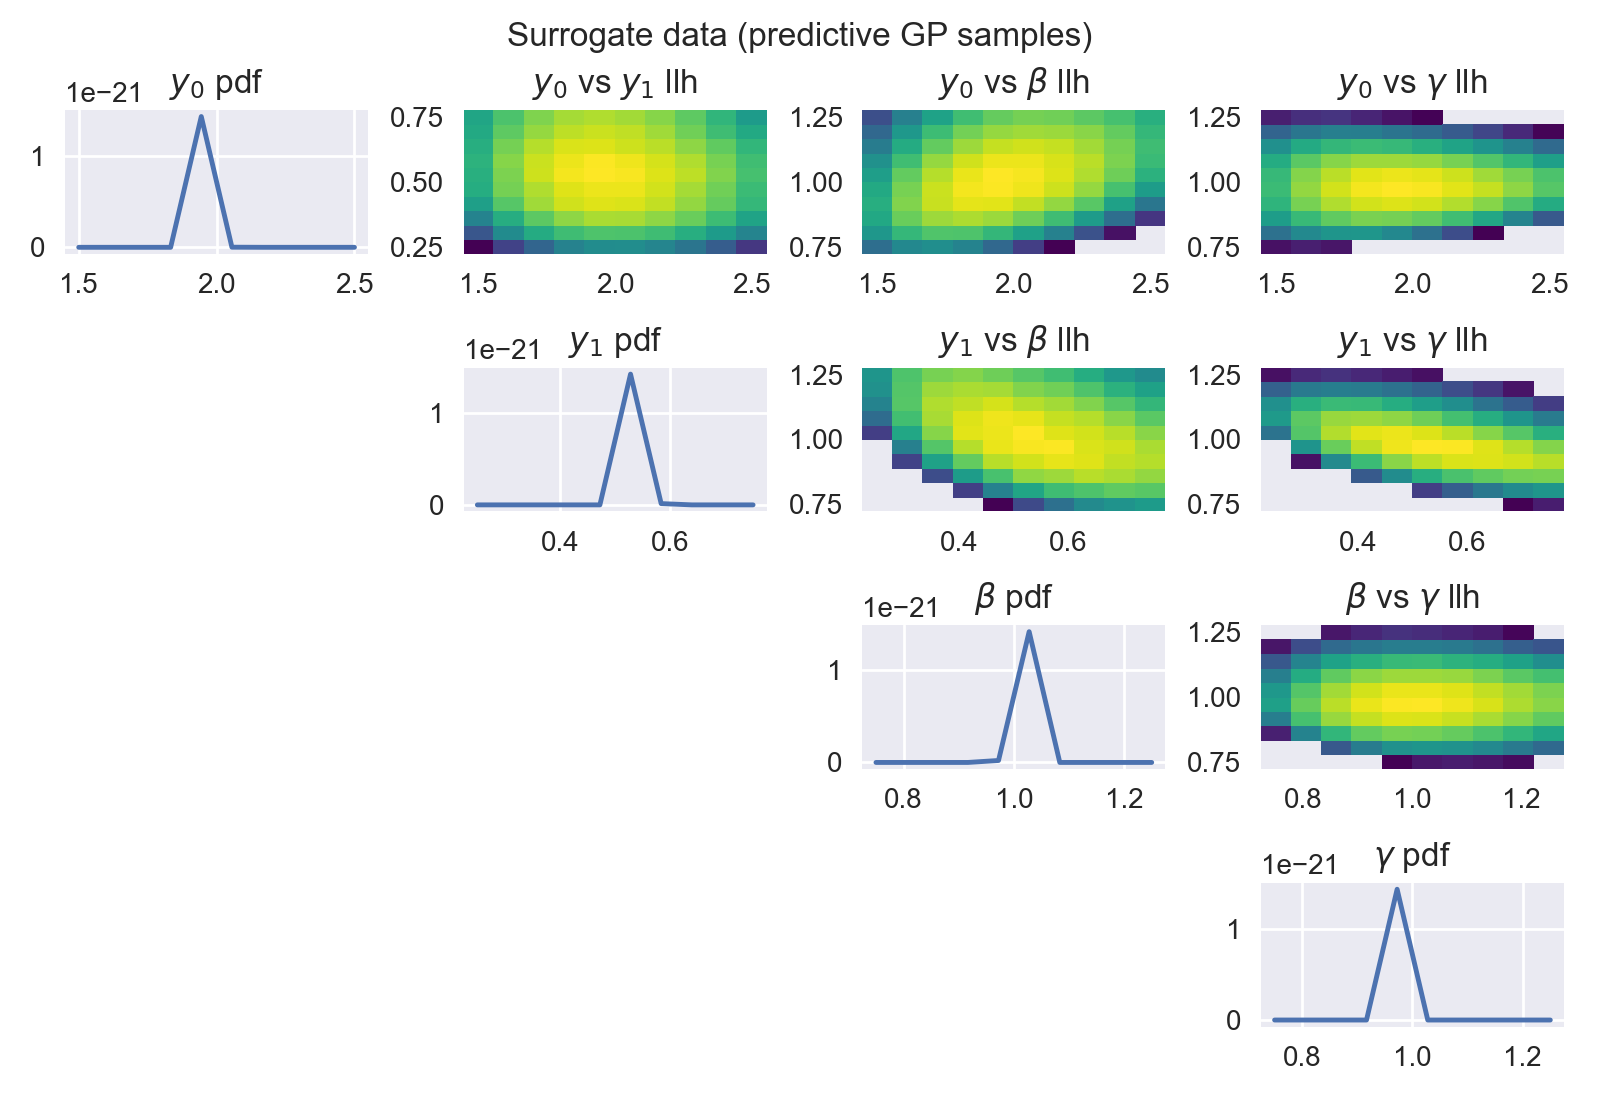

<ipython-input-93-ae3945bcc15a>:13: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(X,Y,np.log(data.sum(axis=(1,3))),cmap='viridis',shading='auto')
<ipython-input-93-ae3945bcc15a>:17: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(X,Y,np.log(data.sum(axis=(1,2))),cmap='viridis',shading='auto')
<ipython-input-93-ae3945bcc15a>:25: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,3))),cmap='viridis',shading='auto')
<ipython-input-93-ae3945bcc15a>:29: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,2))),cmap='viridis',shading='auto')
<ipython-input-93-ae3945bcc15a>:37: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,1))),cmap='viridis',shading='auto')


In [93]:
data = pdf_sur2

fig = plt.figure()
plt.subplot(441)
plt.plot(y0_,data.sum(axis=(1,2,3)))
plt.title('$y_0$ pdf')
plt.subplot(442)
X,Y = np.meshgrid(y0_,y1_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(2,3))),cmap='viridis',shading='auto')
plt.title('$y_0$ vs $y_1$ llh')
plt.subplot(443)
X,Y = np.meshgrid(y0_,beta_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(1,3))),cmap='viridis',shading='auto')
plt.title('$y_0$ vs $\\beta$ llh')
plt.subplot(444)
X,Y = np.meshgrid(y0_,gamma_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(1,2))),cmap='viridis',shading='auto')
plt.title('$y_0$ vs $\\gamma$ llh')

plt.subplot(446)
plt.plot(y1_,data.sum(axis=(0,2,3)))
plt.title('$y_1$ pdf')
plt.subplot(447)
X,Y = np.meshgrid(y1_,beta_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,3))),cmap='viridis',shading='auto')
plt.title('$y_1$ vs $\\beta$ llh')
plt.subplot(448)
X,Y = np.meshgrid(y1_,gamma_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,2))),cmap='viridis',shading='auto')
plt.title('$y_1$ vs $\\gamma$ llh')

plt.subplot(4,4,11)
plt.plot(beta_,data.sum(axis=(0,1,3)))
plt.title('$\\beta$ pdf')
plt.subplot(4,4,12)
X,Y = np.meshgrid(beta_,gamma_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,1))),cmap='viridis',shading='auto')
plt.title('$\\beta$ vs $\\gamma$ llh')

plt.subplot(4,4,16)
plt.plot(gamma_,data.sum(axis=(0,1,2)))
plt.title('$\\gamma$ pdf')

plt.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle("Surrogate data (predictive GP samples)")
plt.show()

<IPython.core.display.Javascript object>


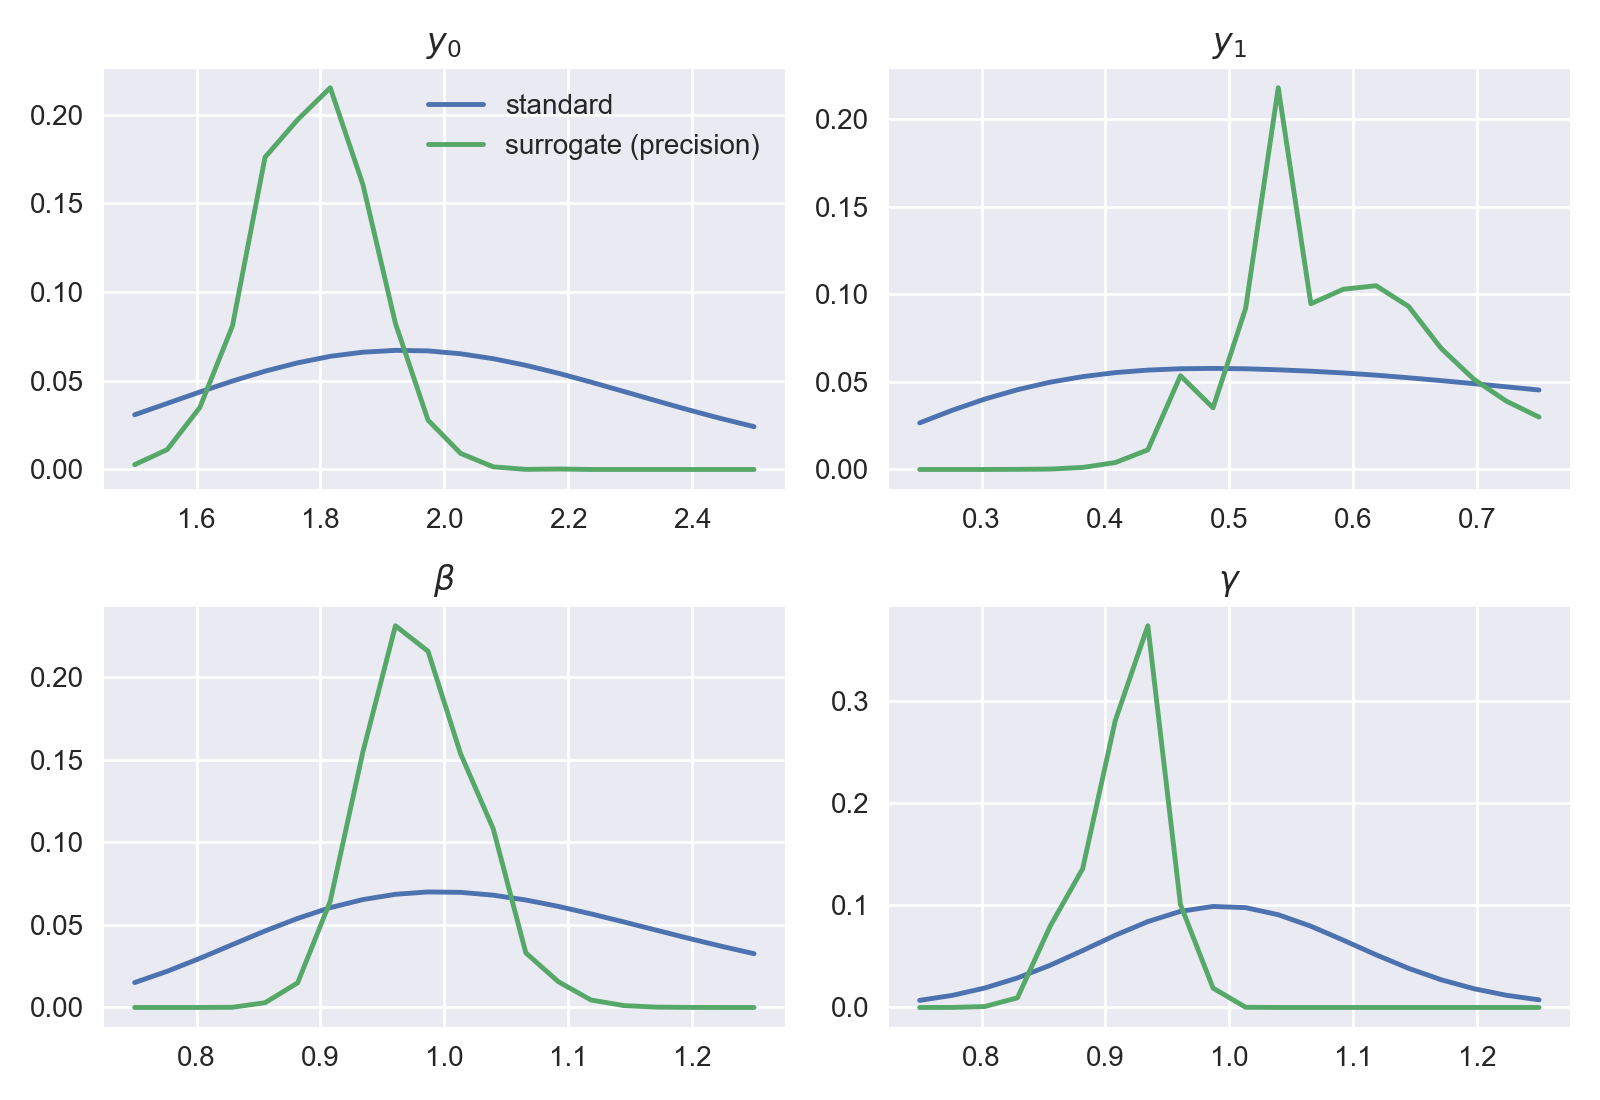

In [46]:
fig = plt.figure()
plt.subplot(221)
d1 = pdf_std.sum(axis=(1,2,3))
d2 = pdf_sur1.sum(axis=(1,2,3))
# d3 = pdf_sur2.sum(axis=(1,2,3))
plt.plot(y0_,d1/d1.sum(),label="standard")
plt.plot(y0_,d2/d2.sum(),label="surrogate (precision)")
# plt.plot(y0_,d3/d3.sum(),label="surrogate (predictive)")
plt.legend(loc='best')
plt.title("$y_0$")
plt.subplot(222)
d1 = pdf_std.sum(axis=(0,2,3))
d2 = pdf_sur1.sum(axis=(0,2,3))
# d3 = pdf_sur2.sum(axis=(0,2,3))
plt.plot(y1_,d1/d1.sum())
plt.plot(y1_,d2/d2.sum())
# plt.plot(y1_,d3/d3.sum())
plt.title("$y_1$")
plt.subplot(223)
d1 = pdf_std.sum(axis=(0,1,3))
d2 = pdf_sur1.sum(axis=(0,1,3))
# d3 = pdf_sur2.sum(axis=(0,1,3))
plt.plot(beta_,d1/d1.sum())
plt.plot(beta_,d2/d2.sum())
# plt.plot(beta_,d3/d3.sum())
plt.title("$\\beta$")
plt.subplot(224)
d1 = pdf_std.sum(axis=(0,1,2))
d2 = pdf_sur1.sum(axis=(0,1,2))
# d3 = pdf_sur2.sum(axis=(0,1,2))
plt.plot(gamma_,d1/d1.sum())
plt.plot(gamma_,d2/d2.sum())
# plt.plot(gamma_,d3/d3.sum())
plt.title("$\\gamma$")

plt.tight_layout()
plt.show()